In [90]:
import qiskit
import qiskit_algorithms
import qiskit_optimization

from qiskit_aer import AerSimulator

from qiskit.primitives import Sampler
# from qiskit.primitives import BackendSamplerV2 
# from qiskit.primitives import StatevectorSampler #takes 2 args but 3 are passed assuming Sampler :(
# from qiskit_ibm_runtime import SamplerV2 #needs backend

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit.library import RYGate, XGate, CXGate
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

from qiskit_algorithms import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA

from qiskit_optimization.algorithms import MinimumEigenOptimizer, SolutionSample, OptimizationResultStatus
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, LinearInequalityToPenalty, QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp # creates QuadraticProgram from docplex model

from qiskit.visualization import plot_histogram, plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_distribution

import networkx as nx
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import math
import time
import contextlib
import io
from IPython.display import display, Math

# from qiskit_algorithms.utils import algorithm_globals
# algorithm_globals.random_seed = 123

import warnings
# Suppress specific DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)


print("qiskit version:",qiskit.__version__)
print("qiskit algorithms version:",qiskit_algorithms.__version__)
print("qiskit optimization version:",qiskit_optimization.__version__)

qiskit version: 1.3.2
qiskit algorithms version: 0.3.1
qiskit optimization version: 0.6.1


In [91]:
# Load MATLAB file
data = scipy.io.loadmat('ifiss3.6/QUBO_4.mat') #16 vars for prob 3, 12 for 4 

# Extract matrices as NumPy arrays
Phi = np.array(data['Phi'])
M = np.array(data['M'].toarray())
Kinv = np.array(data['Kinv'])
yhat_vec = np.array(data['yhat_vec']).squeeze()  # for 1D array

# Hamming weight upper bound
s=3

print('Phi shape:', Phi.shape)
print('M shape:', M.shape)
print('Kinv shape:', Kinv.shape)
print('yhat_vec shape:', yhat_vec.shape)

Phi shape: (289, 12)
M shape: (289, 289)
Kinv shape: (289, 289)
yhat_vec shape: (289,)


In [92]:
def generate_pde_qubo(M, Kinv, Phi, yd):
    
    Q = np.array((1/2) * Phi.T @ M @ Kinv @ M @ Kinv @ M @ Phi)

    q = np.array((1/2) * (yd.T @ M @ Kinv @ M @ Phi).T - (Phi.T @ M @ Kinv.T @ M @ yd))

    c = np.array((1/2) * yd.T @ M @ yd)

    return Q, q, c

Q, q, c = generate_pde_qubo(M, Kinv, Phi, yhat_vec)

print('Q shape: ', Q.shape)
print('q shape: ', q.shape)
print('c shape: ', c.shape)

Q shape:  (12, 12)
q shape:  (12,)
c shape:  ()


In [93]:
def build_original_bqo(Q, q, c, s):
    """
    Build the original binary quadratic optimization (BQP) problem.
    
    Args:
        Q (np.ndarray): Quadratic coefficients matrix.
        q (np.ndarray): Linear coefficients vector.
        c (float): Constant term.
        s (int): Hamming weight upper bound.
    
    Returns:
        QuadraticProgram: The BQP problem instance.
    """
    # make an empty problem
    n = q.size
    total_vars = q.size + s

    # Step 1: Pad original Q and q to size (n + log_s)
    padded_Q = np.zeros((total_vars, total_vars))
    padded_Q[:n, :n] = Q  # original Q in top-left block

    padded_q = np.zeros(total_vars)
    padded_q[:n] = q  # original q


    bqo = QuadraticProgram("PDE constrained BQO")
    binary_vars = [bqo.binary_var(name=f"x{i}") for i in range(total_vars)]

    # Add the Hamming weight constraint: sum(x[i]) == s
    bqo.linear_constraint(
        linear={f"x{i}": 1 for i in range(total_vars)},
        sense="==",
        rhs=s,
        name="hamming_weight"
    )

    # Add objective function using lists/arrays
    bqo.minimize(
        constant=c,
        linear=padded_q,
        quadratic=padded_Q
        )
    
    return bqo

bqo = build_original_bqo(Q, q, c, s)

In [94]:
def build_qubo(Q, q, c, s, lam):
    """
    Build the QUBO matrix and vector for the binary expansion slack formulation.
    """
    n = q.shape[0]
    log_s = int(np.ceil(np.log2(s + 1)))  # number of slack variables
    
    total_vars = n + log_s

    # Step 1: Pad original Q and q to size (n + log_s)
    padded_Q = np.zeros((total_vars, total_vars))
    padded_Q[:n, :n] = Q  # original Q in top-left block

    padded_q = np.zeros(total_vars)
    padded_q[:n] = q  # original q

    # Step 2: Build the penalty matrices
    # e = vector of ones for original variables u
    e = np.ones(n)
    # a = binary weights for slack variables v
    a = np.array([2**j for j in range(log_s)])

    # Stack e and a to form t = (e, a)
    t = np.concatenate([e, a])

    # Compute hat_Q = t * t^T
    hat_Q = np.outer(t, t)

    # Compute hat_q = -2 * s * t
    hat_q = -2 * s * t

    # Compute penalty constant term
    penalty_const = s**2

    # Step 3: Add penalty terms to padded Q and q
    Q_total = padded_Q + lam * hat_Q
    q_total = padded_q + lam * hat_q
    c_total = c + lam * penalty_const

    return Q_total, q_total, c_total, total_vars

# Calculating Lambda:

In [95]:
from scipy.optimize import minimize

def compute_lambda(Q, q, c, s):
    """
    Compute a practical bound on the penalty parameter λ for QUBO.

    Parameters:
        Q (ndarray): Quadratic matrix (n x n).
        q (ndarray): Linear vector (n,).
        c (float): Constant term.
        s (int): Knapsack constraint upper bound.

    Returns:
        lam (float): Lower bound on λ.
    """
    n = q.shape[0]

    # Step 1: Solve relaxed problem over [0,1]^n
    def objective(u):
        return u @ Q @ u + q @ u + c

    bounds = [(0, 1)] * n
    constraints = ()  # No constraints in relaxed unconstrained problem

    u0 = np.zeros(n)  # Initial guess
    result = minimize(objective, u0, bounds=bounds, method="SLSQP")

    if not result.success:
        raise RuntimeError("Relaxed problem did not converge")

    u_relaxed = result.x
    lb = result.fun

    # Step 2: Heuristic to find feasible solution
    top_s_indices = np.argsort(-u_relaxed)[:s]  # Indices of top s entries
    u_feasible = np.zeros(n)
    u_feasible[top_s_indices] = 1

    ub = u_feasible @ Q @ u_feasible + q @ u_feasible + c

    # Step 3: Compute λ
    lam = ub - lb

    print(f"Relaxed lower bound (lb): {lb}")
    print(f"Feasible upper bound (ub): {ub}")
    print(f"Recommended λ: {lam}")

    return lam

lam = compute_lambda(Q, q, c, s)
print("Computed penalty parameter λ:", lam)

# lam = 10**2  # Penalty parameter

Relaxed lower bound (lb): 4.355315559911821
Feasible upper bound (ub): 36.74872354831147
Recommended λ: 32.393407988399645
Computed penalty parameter λ: 32.393407988399645


In [96]:
# Build QUBO
Q_total, q_total, c_total, total_vars = build_qubo(Q, q, c, s, lam)

# Create Quadratic Program
qubo = QuadraticProgram("Binary expansion QUBO")
for i in range(total_vars):
    qubo.binary_var(name=f"x{i}")

# Objective function: no constraints needed anymore
qubo.minimize(
    constant=c_total,
    linear=q_total,
    quadratic=Q_total
)
print(qubo.prettyprint())

Problem name: Binary expansion QUBO

Minimize
  37.601027634980845*x0^2 + 75.20205526996169*x0*x1 + 75.20205526996169*x0*x10
  + 75.20205526996169*x0*x11 + 64.78681597679929*x0*x12
  + 129.57363195359858*x0*x13 + 75.20205526996169*x0*x2
  + 75.20205526996169*x0*x3 + 75.20205526996169*x0*x4 + 75.20205526996169*x0*x5
  + 75.20205526996169*x0*x6 + 75.20205526996169*x0*x7 + 75.20205526996169*x0*x8
  + 75.20205526996169*x0*x9 + 37.601027634980845*x1^2 + 75.20205526996169*x1*x10
  + 75.20205526996169*x1*x11 + 64.78681597679929*x1*x12
  + 129.57363195359858*x1*x13 + 75.20205526996169*x1*x2
  + 75.20205526996169*x1*x3 + 75.20205526996169*x1*x4 + 75.20205526996169*x1*x5
  + 75.20205526996169*x1*x6 + 75.20205526996169*x1*x7 + 75.20205526996169*x1*x8
  + 75.20205526996169*x1*x9 + 37.601027634980845*x10^2
  + 75.20205526996169*x10*x11 + 64.78681597679929*x10*x12
  + 129.57363195359858*x10*x13 + 37.601027634980845*x11^2
  + 64.78681597679929*x11*x12 + 129.57363195359858*x11*x13
  + 32.3934079883996

In [97]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

# Assuming qubo is an instance of QuadraticProgram
# Create a classical solver
eigen_solver = NumPyMinimumEigensolver()

# Create the optimizer
optimizer = MinimumEigenOptimizer(eigen_solver)

# Solve the problem
result = optimizer.solve(qubo)
optimal_value = result.fval

# Print the solution
print("solution:", result.prettyprint())
print("Hamming weight:", sum(result.x))

solution: objective function value: 5.626523996144101
variable values: x0=0.0, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0, x6=0.0, x7=0.0, x8=1.0, x9=0.0, x10=0.0, x11=0.0, x12=0.0, x13=1.0
status: SUCCESS
Hamming weight: 2.0


In [98]:
# parameters
backend = AerSimulator()
sampler = Sampler()
cvar_alpha = 1 # alpha for CVaR aggregation in (0,1], 1 for full distribution, 0 for only the best solution
shots = 1024/cvar_alpha
sampler.set_options(shots=shots, backend=backend)
optimizer = COBYLA()
reps = 3
initial_point = np.zeros(2 * reps)

# solvers
qaoa = QAOA(
    sampler=sampler, 
    optimizer=optimizer, 
    reps=reps, 
    initial_point=initial_point,
    aggregation=cvar_alpha
    )

# create minimum eigen optimizer based on solver used
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

#=====================================================
# Noisy QAOA
#=====================================================
# parameters
# Get the noise model and coupling map from the backend
backend = FakeAlmadenV2()
backend = AerSimulator.from_backend(backend)
sampler = Sampler()
cvar_alpha = 1 # alpha for CVaR aggregation in (0,1], 1 for full distribution, 0 for only the best solution
shots = 1024/cvar_alpha
sampler.set_options(shots=shots, backend=backend)
optimizer = COBYLA()
reps = 3
initial_point = np.zeros(2 * reps)

# solvers
noisy_qaoa = QAOA(
    sampler=sampler, 
    optimizer=optimizer, 
    reps=reps, 
    initial_point=initial_point,
    aggregation=cvar_alpha
    )

# create minimum eigen optimizer based on solver used
noisy_qaoa_optimizer = MinimumEigenOptimizer(noisy_qaoa)


#===Classical solver===
np_solver = NumPyMinimumEigensolver() # exact classical solver
np_optimizer = MinimumEigenOptimizer(np_solver)

In [99]:
def check_feasibility(samples):
    total_count = len(samples)
    infeasible_count = 0
    n = q.shape[0]
    log_s = int(np.ceil(np.log2(s + 1)))  # number of slack variables

    for sample in samples:
        assert len(sample.x) == n + log_s, "Sample size does not match expected size."
        x = sample.x
        u = x[:n]                      # original variables
        v = x[n:n+log_s]               # slack variables

        # Compute e^T u + a^T v
        sum_u = np.sum(u)
        weights = np.array([2**j for j in range(log_s)])
        sum_v = np.dot(weights, v)
        total = sum_u + sum_v

        if total != s:
            infeasible_count += 1
        
    feasibility_ratio = (total_count - infeasible_count) / total_count
    print(f"Total samples: {total_count}, Infeasible samples: {infeasible_count}, Feasibility ratio: {feasibility_ratio:.2f}")

def check_feasibility_bqo(samples):
    total_count = len(samples)
    infeasible_count = 0
    n = q.shape[0]

    for sample in samples:
        x = sample.x[:n]
        # Check Hamming weight constraint
        if sum(x) > s:
            infeasible_count += 1
        
    feasibility_ratio = (total_count - infeasible_count) / total_count
    print(f"Total samples: {total_count}, Infeasible samples: {infeasible_count}, Feasibility ratio: {feasibility_ratio:.2f}")



In [100]:
classical_result = np_optimizer.solve(qubo)
classical_samples = classical_result.samples
print(classical_samples)

check_feasibility(classical_samples)
check_feasibility_bqo(classical_samples)

[SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), fval=5.626523996144101, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)]
Total samples: 1, Infeasible samples: 0, Feasibility ratio: 1.00
Total samples: 1, Infeasible samples: 0, Feasibility ratio: 1.00


In [101]:
import concurrent.futures

def run_optimizer(optimizer, name, model):
    """Run a single optimizer and return results"""
    result = optimizer.solve(model)
    return {'name': name, 'result': result}

# Run both QAOA optimizers in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    # Submit both tasks
    future_noiseless = executor.submit(run_optimizer, qaoa_optimizer, "Noiseless QAOA", qubo)
    future_noisy = executor.submit(run_optimizer, noisy_qaoa_optimizer, "Noisy QAOA", qubo)
    
    # Get results
    noiseless_result = future_noiseless.result()
    noisy_result = future_noisy.result()

# Access the results
qaoa_result = noiseless_result['result']
noisy_qaoa_result = noisy_result['result']

In [102]:
n = q.shape[0]  # number of original variables
log_s = int(np.ceil(np.log2(s + 1)))  # number of slack variables

samples = qaoa_result.samples
check_feasibility(samples)
check_feasibility_bqo(samples)

for sample in samples:
    # Evaluate objective function and strip slack variables
    sample.fval = qubo.objective.evaluate(sample.x)
    sample.x = sample.x[:q.size] # remove padding

# Sort samples in ascending order of objective value
samples.sort(key=lambda x: x.fval, reverse=False)

# samples

Total samples: 275, Infeasible samples: 221, Feasibility ratio: 0.20
Total samples: 275, Infeasible samples: 71, Feasibility ratio: 0.74


In [103]:
noisy_samples = noisy_qaoa_result.samples
check_feasibility(noisy_samples)
check_feasibility_bqo(noisy_samples)

for sample in noisy_samples:
    # Evaluate objective function and strip slack variables
    sample.fval = qubo.objective.evaluate(sample.x)
    sample.x = sample.x[:q.size] # remove padding

samples.sort(key=lambda x: x.fval, reverse=False) #fvals are in ascending order so best first (for minimization)

# noisy_samples

Total samples: 510, Infeasible samples: 468, Feasibility ratio: 0.08
Total samples: 510, Infeasible samples: 183, Feasibility ratio: 0.64


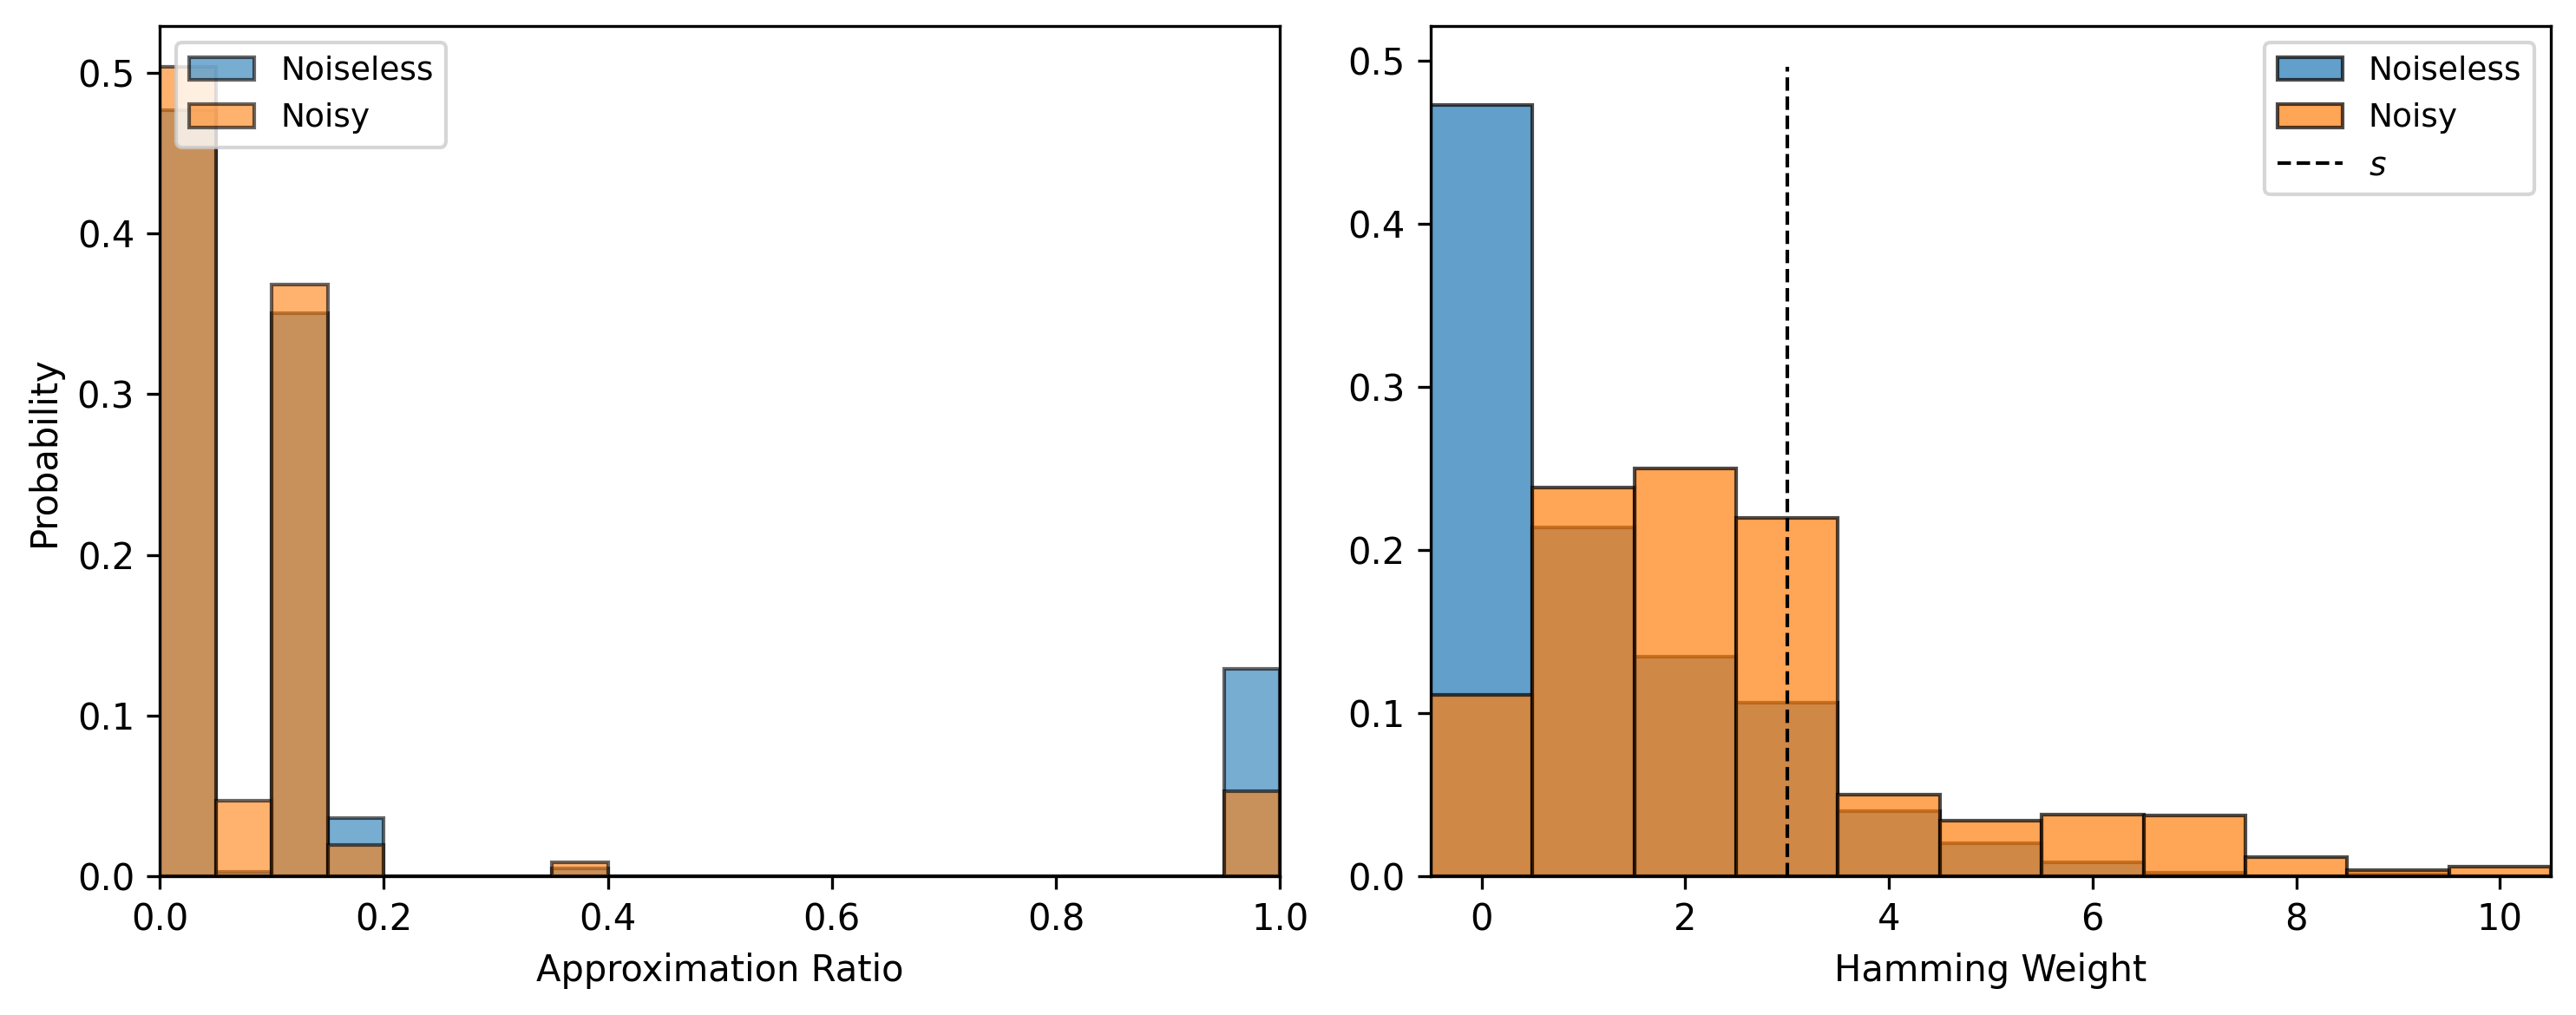

In [104]:
# --- (Re)compute your empirical data arrays ---
probabilities       = [s.probability for s in samples]
approx_ratios       = [optimal_value / s.fval   for s in samples]
hamming_weights     = [sum(s.x)                for s in samples]

noisy_probabilities = [s.probability for s in noisy_samples]
noisy_approx_ratios = [optimal_value / s.fval   for s in noisy_samples]
noisy_hamming_weights = [sum(s.x)                for s in noisy_samples]

# --- Define common bins ---
# For approximation ratio: from 0 to 1 in 20 equal bins
ratio_bins   = np.linspace(0.0, 1.0, 21)

# For Hamming weight: integer bins from min to max, with half‑bin padding
max_h = max(max(hamming_weights), max(noisy_hamming_weights))
hamming_bins = np.arange(-0.5, max_h + 1.5, 1.0)

# --- Create figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# (a) Approximation Ratio
ax1.hist(approx_ratios,
         bins=ratio_bins,
         weights=probabilities,
         alpha=0.6,
         edgecolor='black',
         label='Noiseless')
ax1.hist(noisy_approx_ratios,
         bins=ratio_bins,
         weights=noisy_probabilities,
         alpha=0.6,
         edgecolor='black',
         label='Noisy')

ax1.set_xlabel("Approximation Ratio", fontsize=10)
ax1.set_ylabel("Probability",        fontsize=10)
ax1.set_xlim(0, 1.0)
ax1.set_xticks(np.linspace(0,1,6))
ax1.legend(loc='upper left', fontsize=9)
# ax1.text(0.02, 0.95, "(a)",
#          transform=ax1.transAxes,
#          fontsize=12, fontweight='bold',
#          va='top')

# (b) Hamming Weight
ax2.hist(hamming_weights,
         bins=hamming_bins,
         weights=probabilities,
         alpha=0.7,
         edgecolor='black',
         label='Noiseless')
ax2.hist(noisy_hamming_weights,
         bins=hamming_bins,
         weights=noisy_probabilities,
         alpha=0.7,
         edgecolor='black',
         label='Noisy')

# vertical line at s
ax2.vlines(s,
           ymin=0,
           ymax=ax2.get_ylim()[1],
           linestyles='dashed',
           linewidth=1,
           color='black',
           label=r'$s$')

ax2.set_xlabel("Hamming Weight", fontsize=10)
ax2.set_xlim(-0.5, max_h + 0.5)
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.legend(loc='upper right', fontsize=9)
# ax2.text(0.02, 0.95, "(b)",
#          transform=ax2.transAxes,
#          fontsize=12, fontweight='bold',
#          va='top')

# --- Final layout and save ---
plt.tight_layout()
plt.savefig("Penalty_hamming_and_approx_ratio.png", bbox_inches='tight')
plt.show()

In [105]:
# We are minimizing fval
best_sample = samples[0]
best_sample_formatted = [int(x_i) for x_i in best_sample.x]
prob_best_sample = best_sample.probability
best_fval = best_sample.fval

samples.sort(key=lambda x: x.probability, reverse=True)
most_probable_sample = samples[0]
most_probable_sample_formatted = [int(x_i) for x_i in most_probable_sample.x]
prob_most_probable_sample = most_probable_sample.probability
most_probable_fval = most_probable_sample.fval

print("====Noiseless QAOA results====")
print(f"Best sample: {best_sample_formatted} with probability {prob_best_sample}")
print(f"Best value: {best_fval}")
print(f"Best approx ratio: {optimal_value / best_fval}")
print()
print(f"Most probable sample: {most_probable_sample_formatted} with probability {prob_most_probable_sample}")
print(f"Most probable value: {most_probable_fval}")
print(f"Most probable approx ratio: {optimal_value / most_probable_fval}")
print()
print()

#=====================================================
# Noisy QAOA
#=====================================================
print("====Noisy QAOA results====")
best_sample = noisy_samples[0]
best_sample_formatted = [int(x_i) for x_i in best_sample.x]
prob_best_sample = best_sample.probability
best_fval = best_sample.fval
noisy_samples.sort(key=lambda x: x.probability, reverse=True)
most_probable_sample = noisy_samples[0]
most_probable_sample_formatted = [int(x_i) for x_i in most_probable_sample.x]
prob_most_probable_sample = most_probable_sample.probability
most_probable_fval = most_probable_sample.fval
print(f"Best sample: {best_sample_formatted} with probability {prob_best_sample}")
print(f"Best value: {best_fval}")
print(f"Best approx ratio: {optimal_value / best_fval}")
print()
print(f"Most probable sample: {most_probable_sample_formatted} with probability {prob_most_probable_sample}")
print(f"Most probable value: {most_probable_fval}")
print(f"Most probable approx ratio: {optimal_value / most_probable_fval}")

====Noiseless QAOA results====
Best sample: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.0107421875
Best value: 5.626523996144101
Best approx ratio: 1.0

Most probable sample: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.24609375
Most probable value: 297.2289550554008
Most probable approx ratio: 0.018929932297798404


====Noisy QAOA results====
Best sample: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.005859375
Best value: 5.626523996144101
Best approx ratio: 1.0

Most probable sample: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] with probability 0.08984375
Most probable value: 38.08169114820362
Most probable approx ratio: 0.14774879545782763
